In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda, Reshape, Flatten, RepeatVector
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.layers.pooling import MaxPooling2D
from keras.models import Model, Sequential
from keras import backend as K
from keras import objectives
from keras.datasets import mnist

Using Theano backend.
Using cuDNN version 5110 on context None
Mapped name None to device cuda: GeForce GT 650M (0000:01:00.0)


In [2]:
# use the sampled latent points to generate new latent points z in the latent space
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(latent_dim,), 
                              mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# custom loss function
def vae_loss(x, x_decoded_mean):
    
    # cross entropy term (reconstruction error)
    xent_loss = original_dim * objectives.binary_crossentropy(x, x_decoded_mean)
#     xent_loss = objectives.mean_squared_error(x, x_decoded_mean)
    
    # KL-divergence term (regularization term)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)  
    
    # sum both terms
    return K.mean(xent_loss + kl_loss)

# apply all layers in a list
def h_apply(h_l, x):
    y = x
    for h in h_l:
        y = h(y)
    return y

In [3]:
# train vae model on mnist data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# (x_train, y_train), (x_test, y_test) = cifar100.load_data()

if len(x_train.shape) < 4:
    x_train = np.expand_dims(x_train, 1)
    x_test = np.expand_dims(x_test, 1)
    
image_dim = x_train[0].shape
original_dim = np.prod(image_dim)
latent_dim = 2
# intermediate_dims = np.array([2048, 1024, 512, 256])
intermediate_dims = np.array([256])

nb_epoch = 10
batch_size = 100
epsilon_std = 1.0e-0

num_filters = 3

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [4]:
# encoder network to map real inputs to latent space
x = Input(shape=(original_dim,))

# h = [Reshape(target_shape=image_dim)]
# h.append(MaxPooling2D(pool_size=(2,2)))
# h.append(Conv2D(activation="relu", filters=num_filters, padding="same", kernel_size=(5, 5)))
# h.append(MaxPooling2D(pool_size=(2, 2)))
# h.append(Conv2D(activation="relu", filters=num_filters, padding="same", kernel_size=(5, 5)))
# h.append(MaxPooling2D(pool_size=(2, 2)))
# h.append(Flatten())
# h.append(Dense(256, activation="relu"))

h = [Dense(256, activation="tanh")]

# compute latent mean and variance         
z_mean = Dense(units=latent_dim)(h_apply(h, x))
z_log_var = Dense(units=latent_dim)(h_apply(h, x))

In [5]:
# generate latent points (lambda function layer)
z = Lambda(function=sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
# z = Dense(2)(h_apply(h, x))

In [6]:
# map sampled latent points back to reconstructed points
# we instantiate these layers separately so as to reuse them later

# decoder_h = Dense(intermediate_dim, activation='relu')
# h_decoded = decoder_h(z)

h_decoded = [Dense(256, activation="tanh")]
h_decoded.append(Dense(original_dim, activation="sigmoid"))

# h_decoded.append(Dense(units=num_filters * image_dim[1] / 4 * image_dim[2] / 4, activation="relu"))
# h_decoded.append(Reshape(target_shape=(num_filters, image_dim[1] / 4, image_dim[2] / 4)))
# h_decoded.append(UpSampling2D(size=(2, 2)))
# h_decoded.append(Conv2D(activation="relu", filters=num_filters, padding="same", kernel_size=(5, 5)))
# h_decoded.append(UpSampling2D(size=(2, 2)))
# h_decoded.append(Conv2D(activation="sigmoid", filters=image_dim[0], padding="same", kernel_size=(5, 5)))

# decoder_mean = Dense(original_dim, activation='sigmoid')(h_decoded[-1])
x_decoded_mean = h_apply(h_decoded, z)
# x_decoded_mean = Flatten()(x_decoded_mean)

In [7]:
# end-to-end autoencoder
vae = Model(x, x_decoded_mean)

# compile model
vae.compile(optimizer="rmsprop", loss=vae_loss)

In [60]:
# train model
vae.fit(x_train, x_train,
        shuffle=True,
        epochs=100,
        batch_size=100,
        validation_split=0.0, verbose=False)

In [61]:
# build a model to project inputs on the latent space
# encoder = Model(x, z_mean)
# encoder = Model(x, z_log_var)
encoder = Model(x, z)

# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)

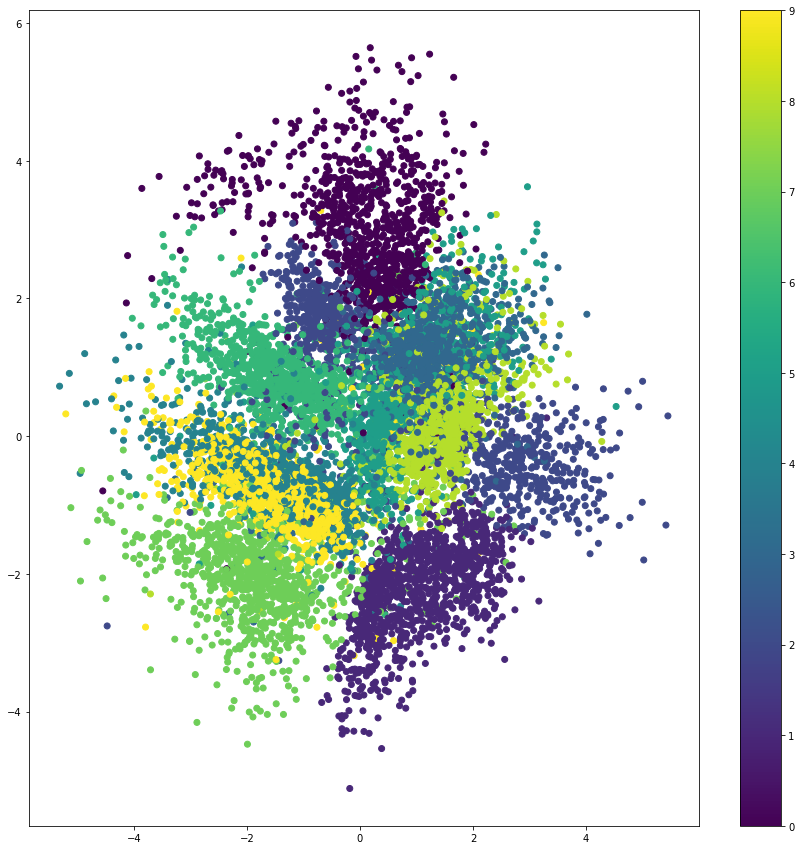

In [62]:
plt.figure(figsize=(15, 15))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()

In [63]:
# generator, from latent space to reconstructed inputs
decoder_input = Input(shape=(latent_dim,))
# _h_decoded = decoder_h(decoder_input)
# _x_decoded_mean = decoder_mean(_h_decoded)
_x_decoded_mean = h_apply(h_decoded, decoder_input)
generator = Model(decoder_input, _x_decoded_mean)

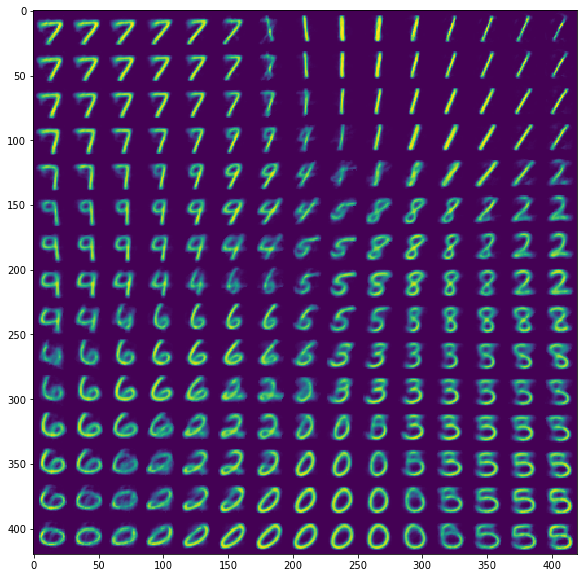

In [64]:
# from PIL import Image

# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
disp_size = np.array(image_dim[1:])
digit_size = image_dim[-1]
disp_size[-2] = n * digit_size
disp_size[-1] = n * digit_size

figure = np.zeros(tuple(disp_size))

# we will sample n points within [-m, m] standard deviations
m = 3 * epsilon_std
grid_x = np.linspace(-m, m, n)
grid_y = np.linspace(-m, m, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]]) * epsilon_std
        x_decoded = generator.predict(z_sample)
        digit = x_decoded.reshape(image_dim[1:])
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)

# figure = np.uint8(figure * 255)
# if figure.ndim > 2:
# #     figure = np.swapaxes(figure, 0, figure.ndim -1)
#     for i in range(figure.ndim - 1):
#         figure = np.swapaxes(figure, i, i+1)
# Image.fromarray(figure)
# img.show()

[[-0.7853711  0.5865954]]


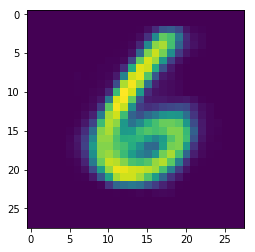

In [74]:
# generate sample according to prior
z_sample = np.random.normal(loc=0, scale=1, size=(1,2))
print z_sample
generated_digit = generator.predict(z_sample).reshape(28, 28)
plt.imshow(generated_digit)

In [3]:
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity

In [4]:
# G = nx.karate_club_graph()
# G = nx.read_gml("dolphins_labelled.gml")
G = nx.read_gml("embedded_karate.gml")
# G = nx.read_gml("embedded_football.gml")
# G = nx.read_gml("embedded_yeast_uetz.gml")
# G = nx.read_gpickle("embedded_yeast_union.gpickle")
# G = nx.read_gpickle("embedded_yeast_reactome.gpickle")
# G = nx.read_gpickle("hierarchical_benchmark.gpickle")
G = max(nx.connected_component_subgraphs(G), key=len)

In [6]:
A = np.array(nx.adj_matrix(G).todense())
D = A.sum(axis=1)

S1 = A
S2 = cosine_similarity(S1)
S3 = cosine_similarity(S2)

S = (0 * np.identity(len(A)) + 1 * S1 + 0 * S2 + 0 * S3)
S /= S.max()

In [7]:
S

array([[ 0.,  1.,  1., ...,  1.,  0.,  0.],
       [ 1.,  0.,  1., ...,  0.,  0.,  0.],
       [ 1.,  1.,  0., ...,  0.,  1.,  0.],
       ..., 
       [ 1.,  0.,  0., ...,  0.,  1.,  1.],
       [ 0.,  0.,  1., ...,  1.,  0.,  1.],
       [ 0.,  0.,  0., ...,  1.,  1.,  0.]])

In [8]:
num_samples, original_dim = A.shape
batch_size = 15
latent_dim = 2
intermediate_dims = [32]
epsilon_std = 1

In [9]:
x = Input(batch_shape=(batch_size, original_dim))

h = []
for i in intermediate_dims:
    h.append(Dense(i, activation='relu'))

z_mean = Dense(latent_dim)(h_apply(h, x))
z_log_var = Dense(latent_dim)(h_apply(h, x))

In [10]:
#generate latent points (lambda function layer)
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

In [11]:
h_decoded = []
for i in intermediate_dims[::-1]:
    h_decoded.append(Dense(i, activation='relu'))

# output layer
h_decoded.append(Dense(original_dim, activation='sigmoid'))

x_decoded_mean = h_apply(h_decoded, z)

In [12]:
# end-to-end autoencoder
vae = Model(x, x_decoded_mean)

# compile VAE model
vae.compile(optimizer="adam", loss=vae_loss)

In [18]:
# train model
vae.fit(S, S,
        shuffle=True,
        epochs=10000,
        batch_size=batch_size,
        validation_split=0, verbose=False)

In [19]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

# display a 2D plot of the digit classes in the latent space
S_encoded = encoder.predict(S, batch_size=batch_size)

In [20]:
polbooks_colour_map = {"c" : "r", "l" : "b", "n" : "g"}

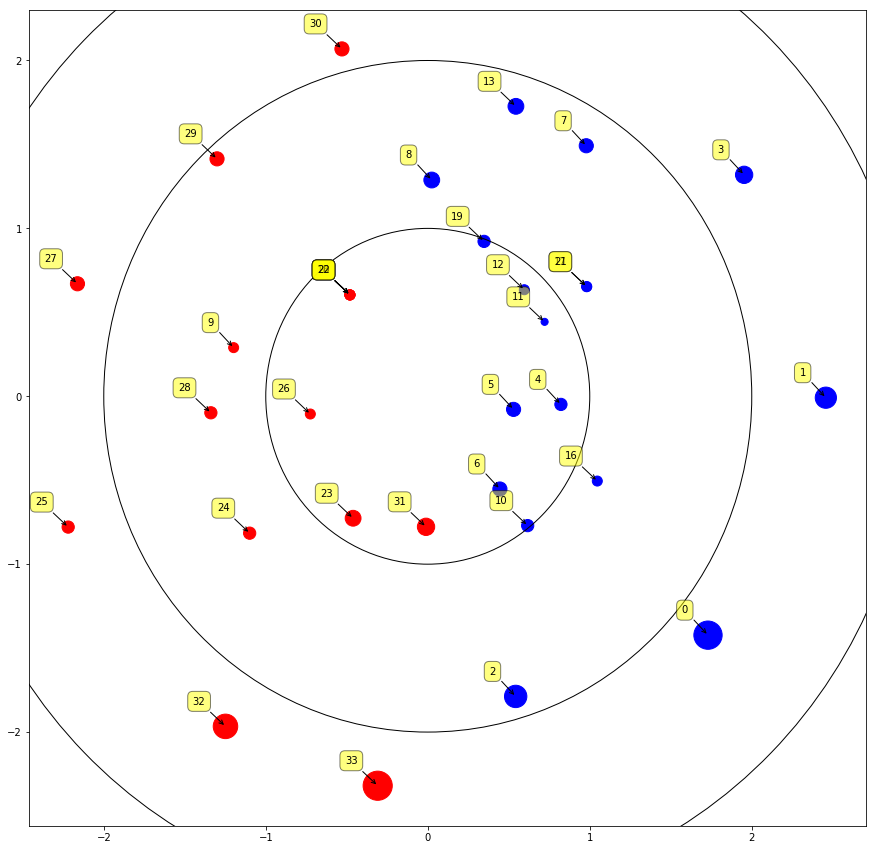

In [23]:
plt.figure(figsize=(15, 15))

for label, i, j in zip(G.nodes(), S_encoded[:, 0], S_encoded[:, 1]):
    plt.annotate(
        label,
        xy=(i, j), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

# nodes = np.array(G.nodes())
# for n1, n2 in G.edges():
#     i, = np.where(nodes == n1)
#     j, = np.where(nodes == n2)
#     plt.plot(S_encoded[(i, j), 0], S_encoded[(i, j), 1], c="k", 
# #              linewidth = 3 * np.exp(- np.linalg.norm(S_encoded[i] - S_encoded[j]) ** 2 / (2 * 0.5 ** 2) ))
#              linewidth = 0.3)
    
plt.scatter(S_encoded[:, 0], 
        S_encoded[:, 1], 
            c=["b" if v=="Mr. Hi" else "r" for v in nx.get_node_attributes(G, "club").values()],
#             c=nx.get_node_attributes(G, "value").values(),
#             c = [polbooks_colour_map[k] for k in nx.get_node_attributes(G,"value").values()],
#             c=nx.get_node_attributes(G, "group").values(), 
#             c="k",
            s=50* A.sum(axis=1))

c1 = plt.Circle((0,0), radius=1, fill=False)
c2 = plt.Circle((0,0), radius=2, fill=False)
c3 = plt.Circle((0,0), radius=3, fill=False)

ax = plt.gca()
ax.add_artist(c1)
ax.add_artist(c2)
ax.add_artist(c3)

In [32]:
# generator, from latent space to reconstructed inputs
decoder_input = Input(shape=(latent_dim,))
# _h_decoded = decoder_h(decoder_input)
# _x_decoded_mean = decoder_mean(_h_decoded)
_x_decoded_mean = h_apply(h_decoded, decoder_input)
generator = Model(decoder_input, _x_decoded_mean)

In [33]:
S_decoded = generator.predict(S_encoded)

In [34]:
S[0]

array([ 1.        ,  0.79166667,  0.69764235,  0.75515518,  0.64433757,
        0.625     ,  0.625     ,  0.6875    ,  0.5559017 ,  0.08838835,
        0.64433757,  0.5       ,  0.58838835,  0.6677051 ,  0.        ,
        0.        ,  0.1767767 ,  0.58838835,  0.        ,  0.57216878,
        0.        ,  0.58838835,  0.        ,  0.        ,  0.07216878,
        0.07216878,  0.        ,  0.0625    ,  0.14433757,  0.        ,
        0.125     ,  0.5       ,  0.10825318,  0.12126781])

In [35]:
S_decoded[0]

array([ 0.86613649,  0.72030002,  0.57630408,  0.66488671,  0.53497201,
        0.49145707,  0.48876709,  0.62186801,  0.4255926 ,  0.10026432,
        0.5417912 ,  0.42511055,  0.52020061,  0.58954251,  0.01162641,
        0.01345193,  0.16513824,  0.52563071,  0.01162871,  0.51553714,
        0.01145144,  0.5287267 ,  0.01292871,  0.00905354,  0.04734233,
        0.03639007,  0.0103556 ,  0.06020286,  0.1416917 ,  0.00849168,
        0.15799077,  0.37140322,  0.09719553,  0.12150224], dtype=float32)

In [61]:
num_samples = 100000
# generate sample according to prior
z_samples = np.random.normal(loc=0, scale=1, size=(num_samples, latent_dim))
# print z_sample
generated_nodes = generator.predict(z_samples)
# plt.imshow(generated_nodes, cmap="hot")

In [62]:
consensus = np.zeros(A.shape)

for i in range(num_samples):
    
    for j in range(len(G)):
        
        p = generated_nodes[i, j]
        
        consensus[j, :] += p * generated_nodes[i]
        consensus[:, j] += p * generated_nodes[i]
        
consensus /= consensus.max()

In [481]:
consensus = np.zeros(A.shape)

for pair in generated_nodes.argsort()[:,-2:]:
    
    consensus[pair[0], pair[1]] += 1
    consensus[pair[1], pair[0]] += 1
    
consensus /= consensus.max()

In [65]:
consensus[consensus < 0.5] = 0

In [31]:
S[0]

array([ 1.        ,  0.80844495,  0.69991533,  0.77020413,  0.62747836,
        0.60824884,  0.60824884,  0.69609248,  0.53488446,  0.19339544,
        0.62747836,  0.50158   ,  0.59035899,  0.66318319,  0.05689017,
        0.05689017,  0.28569619,  0.58372225,  0.05689017,  0.5602661 ,
        0.05689017,  0.58372225,  0.05689017,  0.06422796,  0.13953449,
        0.13972499,  0.06485153,  0.16930689,  0.25233338,  0.06390766,
        0.21038403,  0.45615053,  0.22862968,  0.23111188])

In [67]:
zip(consensus[0], nx.get_node_attributes(G, "group").values())

[(0.74183578657940197, 2),
 (0.0, 1),
 (0.0, 2),
 (0.0, 3),
 (0.0, 4),
 (0.0, 1),
 (0.0, 1),
 (0.0, 1),
 (0.53332379894685022, 3),
 (0.0, 1),
 (0.61432864402805232, 2),
 (0.0, 4),
 (0.0, 3),
 (0.0, 1),
 (0.61986177619955563, 3),
 (0.57746884303826163, 4),
 (0.0, 3),
 (0.0, 1),
 (0.0, 4),
 (0.0, 1),
 (0.58193855893915836, 3),
 (0.0, 4),
 (0.0, 1),
 (0.0, 4),
 (0.0, 2),
 (0.0, 1),
 (0.0, 1),
 (0.0, 1),
 (0.0, 2),
 (0.0, 4),
 (0.0, 2),
 (0.0, 1),
 (0.0, 1),
 (0.0, 3),
 (0.0, 3),
 (0.0, 4),
 (0.0, 3),
 (0.5660084138377518, 3),
 (0.0, 3),
 (0.0, 3),
 (0.62247776669637978, 3),
 (0.0, 1),
 (0.64389368610581343, 2),
 (0.0, 3),
 (0.0, 3),
 (0.58546279002066581, 4),
 (0.0, 3),
 (0.64676339601754129, 2),
 (0.0, 1),
 (0.0, 3),
 (0.60407263493465158, 3),
 (0.0, 4),
 (0.0, 3),
 (0.0, 3),
 (0.0, 1),
 (0.0, 4),
 (0.0, 1),
 (0.0, 1),
 (0.0, 3),
 (0.0, 3),
 (0.0, 1),
 (0.0, 3)]

In [464]:
generated_nodes[generated_nodes < 1e-1] = 0

In [442]:
generated_nodes[10]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.99996364,  0.99994934], dtype=float32)

In [448]:
zip(nx.get_node_attributes(G, "club").values(), generated_nodes[50])

[(u'Mr. Hi', 0.0),
 (u'Mr. Hi', 0.0),
 (u'Mr. Hi', 0.27149498),
 (u'Mr. Hi', 0.0),
 (u'Mr. Hi', 0.0),
 (u'Mr. Hi', 0.0),
 (u'Mr. Hi', 0.0),
 (u'Mr. Hi', 0.0),
 (u'Mr. Hi', 1.0),
 (u'Officer', 0.23721263),
 (u'Mr. Hi', 0.0),
 (u'Mr. Hi', 0.0),
 (u'Mr. Hi', 0.0),
 (u'Mr. Hi', 0.26248726),
 (u'Officer', 0.99999964),
 (u'Officer', 0.99999952),
 (u'Mr. Hi', 0.0),
 (u'Mr. Hi', 0.0),
 (u'Officer', 0.9999994),
 (u'Mr. Hi', 0.2541348),
 (u'Officer', 0.99999952),
 (u'Mr. Hi', 0.0),
 (u'Officer', 0.99999952),
 (u'Officer', 0.99999952),
 (u'Officer', 0.0),
 (u'Officer', 0.0),
 (u'Officer', 0.39176771),
 (u'Officer', 0.30275258),
 (u'Officer', 0.25271845),
 (u'Officer', 0.99998796),
 (u'Officer', 0.99990678),
 (u'Officer', 0.9998216),
 (u'Officer', 0.41501677),
 (u'Officer', 0.55460572)]

In [283]:
combined = np.zeros((len(A) + num_samples, len(A) + num_samples))

In [292]:
combined[:len(A), :len(A)] = A
combined[len(A):, :len(A)] = generated_nodes
combined[:len(A), len(A):] = generated_nodes.T

In [293]:
H = nx.from_numpy_matrix(combined)

In [294]:
nx.number_of_nodes(H)

84

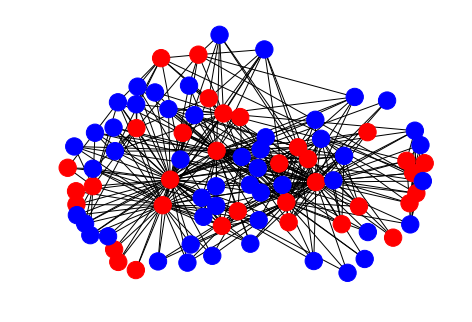

In [295]:
nx.draw(H, node_color=["r" if n < nx.number_of_nodes(G) else "b" for n in H.nodes()])

In [472]:
consensus = np.zeros(A.shape)

In [473]:
for node in generated_nodes:
    
    connected_nodes = np.where(node > 0)[0]
    
    for n1 in connected_nodes:
        
        for n2 in connected_nodes:
            
            consensus[n1, n2] += node[n1] * node[n2]

consensus /= consensus.max()

In [474]:
consensus[0]

array([  8.73112989e-01,   4.06014029e-01,   3.25204425e-01,
         2.64935071e-01,   1.07831287e-01,   1.09712519e-01,
         7.95104336e-02,   1.13546645e-01,   5.01030562e-02,
         2.63433887e-02,   7.11026799e-02,   4.40562043e-03,
         5.79920483e-02,   1.15678519e-01,   0.00000000e+00,
         0.00000000e+00,   7.67552780e-02,   3.13123933e-02,
         0.00000000e+00,   3.05986134e-02,   0.00000000e+00,
         3.12678321e-02,   0.00000000e+00,   1.11495196e-04,
         6.57037518e-02,   6.63964590e-02,   4.82391785e-05,
         3.19835936e-02,   9.36948664e-02,   5.55047790e-03,
         1.16670926e-01,   4.25396764e-03,   2.37303380e-01,
         3.61210933e-01])

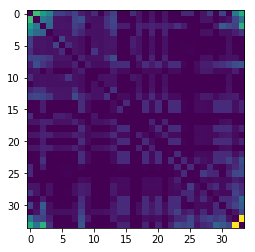

In [471]:
plt.imshow(consensus)

In [356]:
generated_nodes.argmax(axis=1)

array([ 57,   5,   5,   4,   4,   5, 102,  48,  57,   0,  94, 102,   0,
       102,   5,  19,  94,   5,  57,   0,  57,   4,   5,   0,   0,  57,
       102, 102, 102,   0,  94,   0,   0,  57,   5,   5,  57,   5,  57,
         4,   4,  48,  57,  57,  57,   5,  57,   5,   4,  57,  94,   3,
         0,  19, 102,  57,   5,  57,   4,  94, 102,   4,  57,   0,  57,
        94, 102,   5,   5,   4,   4,   4, 102,   5,  94,  57,   5,   4,
         5,  48,  57,   5,   5, 102,   5,   4,   0,  94,   0,   0,  57,
        48,   0,   5, 102,  57,   4,  57,   5,   4])

In [329]:
a = np.array([[4,3,6,1],[5,4,1,2]])

In [335]:
a.argsort(axis=1)[:,-2:]

array([[0, 2],
       [1, 0]])

In [49]:
from sklearn.manifold import MDS

In [50]:
mds = MDS(dissimilarity="precomputed", n_components=2, metric=True, max_iter=1000)

In [51]:
D = nx.floyd_warshall_numpy(G)

In [52]:
D_t = mds.fit_transform(D)

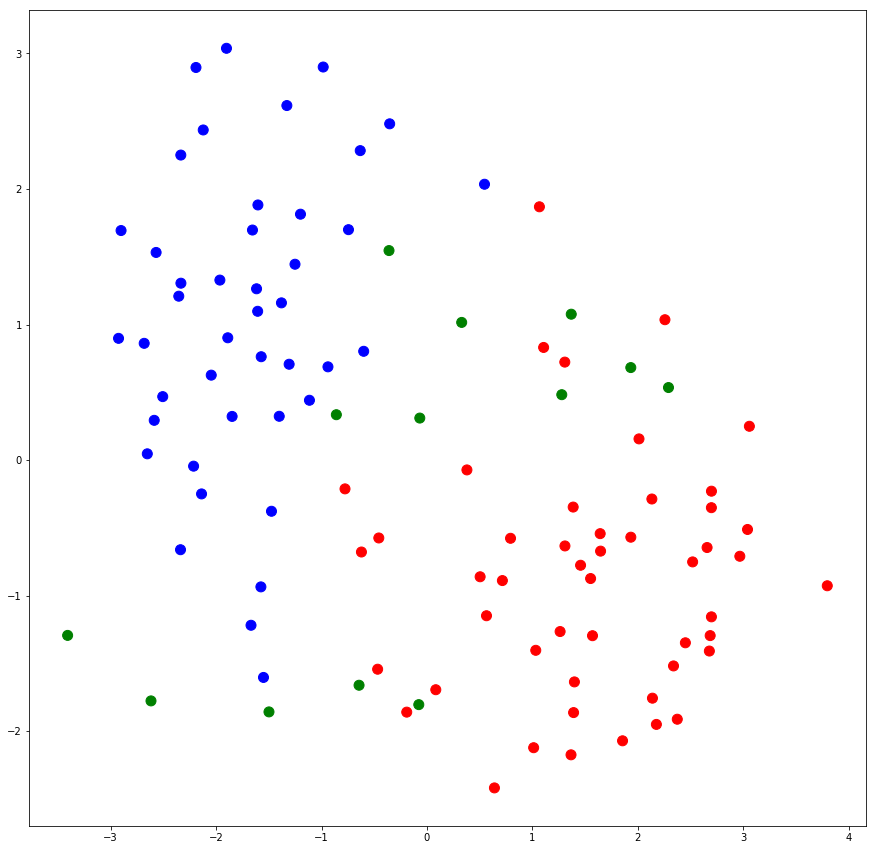

In [53]:
plt.figure(figsize=(15, 15))
plt.scatter(D_t[:, 0], 
            D_t[:, 1], 
#             c=["b" if v=="Mr. Hi" else "r" for v in nx.get_node_attributes(G, "club").values()],
#             c=nx.get_node_attributes(G, "value").values(), 
            c = [polbooks_colour_map[k] for k in nx.get_node_attributes(G,"value").values()],
#             c=nx.get_node_attributes(G, "group").values(), 
#             c="k",
            s=100)
# nodes = np.array(G.nodes())
# for n1, n2 in G.edges():
#     i, = np.where(nodes == n1)
#     j, = np.where(nodes == n2)
#     plt.plot(S_t[(i, j), 0], S_t[(i, j), 1], c="k", 
#              linewidth = 1e-1 * np.exp(- np.linalg.norm(S_t[i] - S_t[j]) ** 2 / (2 * 0.2 ** 2) ))